In [234]:
!pip install plotly

In [235]:
!pip install statsmodels

In [236]:
!pip install missingno

## Import the required Libraries

In [237]:
import pandas as pd
import re
import os
import numpy as np
import datetime
import plotly.express as px

## Merge Files

In [238]:

raw_data_folder = '/Users/kaushikmanjunatha/Documents/Project/Data/raw'
merged_data_folder = '/Users/kaushikmanjunatha/Documents/Project/Data/merged'


if not os.path.exists(merged_data_folder):
    os.makedirs(merged_data_folder)


dataframes = []

# Loop through the files in the raw data folder
for file_name in os.listdir(raw_data_folder):
    if file_name.endswith('.csv'):  
        file_path = os.path.join(raw_data_folder, file_name)
       
        df = pd.read_csv(file_path)
        dataframes.append(df)

# Concatenate all dataframes and keep only one header
merged_df = pd.concat(dataframes, ignore_index=True)


merged_file_path = os.path.join(merged_data_folder, 'merged_data.csv')


merged_df.to_csv(merged_file_path, index=False)

# Output the merged file path
print(f'Merged file saved at: {merged_file_path}')

Merged file saved at: /Users/kaushikmanjunatha/Documents/Project/Data/merged/merged_data.csv


## Data Pre Processing

In [239]:

df = pd.read_csv('/Users/kaushikmanjunatha/Documents/Project/Data/merged/merged_data.csv')

# Remove rows where "Car Name" is blank (NaN or empty string)
df = df[df['Car Name'].notna() & df['Car Name'].str.strip().ne('')]


df.to_csv('/Users/kaushikmanjunatha/Documents/Project/Data/merged/cleaned_merged_data.csv', index=False)


In [240]:
df.shape

(15525, 10)

In [241]:
df = pd.read_csv('/Users/kaushikmanjunatha/Documents/Project/Data/merged/cleaned_merged_data.csv')

In [242]:


# Extract the year from 'Car Name'
df['Year'] = df['Car Name'].apply(lambda x: re.search(r'\b(19|20)\d{2}\b', x).group() if pd.notna(x) and re.search(r'\b(19|20)\d{2}\b', x) else 'Unknown')

# Extract the make and model from 'Car Name'
def extract_make_model(car_name):
    if pd.isna(car_name):  # Handle NaN cases in Car Name
        return 'Unknown', 'Unknown'
    
    parts = car_name.split()
    
    if len(parts) < 3:
        return ('Unknown', 'Unknown')

    make = parts[1]
    model = ' '.join(parts[2:])
    
    return make, model


df['Make'], df['Model'] = zip(*df['Car Name'].apply(extract_make_model))

# calculate (current year - car make year)
current_year = datetime.datetime.now().year

# cases where the year is not 'Unknown'
df['Age'] = df['Year'].apply(lambda x: current_year - int(x) if x.isdigit() else 'Unknown')

#  Replace non-numeric prices like 'Not Priced' with NaN, then convert 'Price' column to numeric format
df['Price_usd'] = pd.to_numeric(df['Price'].replace({'\$': '', ',': ''}, regex=True).replace('Not Priced', pd.NA), errors='coerce')

#  Convert 'Reviews' column to numeric format, remove the "reviews" text
df['Reviews'] = pd.to_numeric(df['Reviews'].replace({' reviews': '', ',': ''}, regex=True), errors='coerce')

# Convert 'Mileage' column to numeric format, remove "mi." text
df['Mileage_miles'] = pd.to_numeric(df['Mileage'].replace({' mi.': '', ',': ''}, regex=True), errors='coerce')

# Split 'Location' into 'County', 'State', and 'Distance'
df[['County', 'State_Distance']] = df['Location'].str.split(',', expand=True)
df[['State', 'Distance']] = df['State_Distance'].str.extract(r'(\w{2})\s\((\d+)\smi\.\)')
df['Distance'] = pd.to_numeric(df['Distance'], errors='coerce')  # Convert Distance to numeric


df.drop(columns=['State_Distance'], inplace=True)


df.to_csv('/Users/kaushikmanjunatha/Documents/Project/Data/processed/processed_data.csv', index=False)


print(df[['Car Name', 'Year', 'Age']].head())


                                  Car Name  Year  Age
0                   2018 Ford F-150 Raptor  2018    6
1  2022 Jeep Wrangler Unlimited 4xe Sahara  2022    2
2    2017 Volvo XC90 Hybrid T8 Inscription  2017    7
3              2023 Toyota Sequoia TRD Pro  2023    1
4              2019 Mercedes-Benz GLC 350e  2019    5


In [243]:
# Missing value
df.isnull().sum()

Car Name                0
Price                   0
Dealer Name             4
Transmission Type       0
Drivetrain              0
Fuel Type               0
Rating               1124
Reviews              1390
Location              915
Mileage                 3
Year                    0
Make                    0
Model                   0
Age                     0
Price_usd             223
Mileage_miles           3
County                915
State                 915
Distance              915
dtype: int64

In [244]:
# Check Duplication
df.duplicated().sum()

2416

In [245]:
# duplicated rows
duplicated_rows = df[df.duplicated()]
print(duplicated_rows)
duplicated_rows.to_csv('/Users/kaushikmanjunatha/Documents/Project/Data/processed/duplicates.csv', index=False)

                                       Car Name    Price   
23                       2018 Ford F-150 Raptor  $40,662  \
46                       2018 Ford F-150 Raptor  $40,662   
69                       2018 Ford F-150 Raptor  $40,662   
92                       2018 Ford F-150 Raptor  $40,662   
115                      2018 Ford F-150 Raptor  $40,662   
...                                         ...      ...   
15496  2020 Ford Fusion Plug-In Hybrid Titanium  $21,375   
15501                2016 Ford C-Max Hybrid SEL  $10,900   
15504                        2020 Ford F-150 XL  $24,987   
15512             2008 Toyota Camry Hybrid Base   $6,995   
15514                2019 Ford Fusion Hybrid SE  $16,000   

                                             Dealer Name Transmission Type   
23                                        Al Packer Ford         Automatic  \
46                                        Al Packer Ford         Automatic   
69                                        Al 

These include duplicate adds or the vehicles with exactly same model year etc and priced at same price by same dealer

In [246]:
df_unique = df.drop_duplicates()

In [247]:
df_unique.shape

(13109, 19)

In [248]:
df_final = df_unique.drop(columns=['Car Name', 'Price', 'Location', 'Mileage'])

In [249]:
df_final.shape

(13109, 15)

In [250]:
df_final.dtypes

Dealer Name           object
Transmission Type     object
Drivetrain            object
Fuel Type             object
Rating               float64
Reviews              float64
Year                  object
Make                  object
Model                 object
Age                    int64
Price_usd            float64
Mileage_miles        float64
County                object
State                 object
Distance             float64
dtype: object

In [251]:
df_final.nunique()

Dealer Name            919
Transmission Type        3
Drivetrain               4
Fuel Type                4
Rating                  35
Reviews                546
Year                    51
Make                    56
Model                 3044
Age                     51
Price_usd             4600
Mileage_miles        12304
County                 199
State                    7
Distance               115
dtype: int64

In [252]:
# renaming the column

df_final = df_final.rename(columns={
    'Rating': 'Dealership Rating',
    'Reviews': 'User Reviews'
})

print(df_final.head())

                   Dealer Name Transmission Type        Drivetrain Fuel Type   
0               Al Packer Ford         Automatic  Four-Wheel Drive    Hybrid  \
1  Heritage Toyota Catonsville         Automatic  Four-Wheel Drive    Hybrid   
2          CarMax Gaithersburg         Automatic  Four-Wheel Drive    Hybrid   
3          Koons Tysons Toyota         Automatic  Four-Wheel Drive    Hybrid   
4             CarMax Milwaukee         Automatic  Four-Wheel Drive    Hybrid   

   Dealership Rating  User Reviews  Year           Make   
0                4.2        2172.0  2018           Ford  \
1                4.3        1794.0  2022           Jeep   
2                0.0          10.0  2017          Volvo   
3                4.7        2443.0  2023         Toyota   
4                0.0           2.0  2019  Mercedes-Benz   

                           Model  Age  Price_usd  Mileage_miles        County   
0                   F-150 Raptor    6    40662.0        90877.0     Baltimore  \
1 

In [253]:
unique_combinations = df_final.groupby(['Year', 'Make', 'Model']).size().reset_index(name='Count')
unique_combinations_sorted = unique_combinations.sort_values(by='Count', ascending=False)
print(unique_combinations_sorted)

      Year    Make                                Model  Count
4533  2021  Nissan                             Rogue SV     32
4928  2022     GMC                 Savana 2500 Work Van     30
4969  2022   Honda                          Civic Sport     30
4561  2021     RAM              1500 Big Horn/Lone Star     29
5217  2022  Nissan                            Sentra SV     26
...    ...     ...                                  ...    ...
2327  2017    Jeep                     Wrangler Rubicon      1
2322  2017    Jeep                Grand Cherokee Summit      1
2321  2017    Jeep              Grand Cherokee Overland      1
2318  2017    Jeep                Grand Cherokee Laredo      1
3242  2019    Land  Rover Range Rover Sport HSE Dynamic      1

[6484 rows x 4 columns]


In [254]:
df_final.shape

(13109, 15)

In [255]:
df_final.describe()

Dealership Rating  User Reviews           Age      Price_usd   
count       12945.000000  12698.000000  13109.000000   12986.000000  \
mean            2.988552    653.871082      5.176139   29943.045049   
std             1.967267   1017.442965      4.879352   26485.638121   
min             0.000000      0.000000     -1.000000    1450.000000   
25%             0.000000     29.000000      2.000000   17998.000000   
50%             4.000000    295.000000      4.000000   24900.000000   
75%             4.600000    882.000000      7.000000   34474.750000   
max             5.000000   6647.000000     69.000000  549988.000000   

       Mileage_miles      Distance  
count   13106.000000  12244.000000  
mean    52662.463376     43.486361  
std     40090.922704     20.692157  
min         0.000000      5.000000  
25%     21833.000000     27.000000  
50%     43458.000000     44.000000  
75%     75685.750000     59.000000  
max    306608.000000    150.000000

In [256]:
df_final.to_csv('/Users/kaushikmanjunatha/Documents/Project/Data/processed/final_processed.csv', index=False)

- Data is collected in multiple files, categorized by region, fuel type, and transmission type. The initial step is merging these into a single dataset.
- The "Make," "Model," and "Year" are clustered together in one field, so they are separated into distinct columns.
- Car age is calculated based on the current year.
- Converted "Price," "Reviews," and "Mileage" to numeric values, handling non-numeric entries.
- Extracted "State" and "County" from the "Location" field.
- Removed duplicate records, which were identical ads with matching specifications and pricing from the same dealership.
- Renamed columns for clarity.

## EDA

In [257]:
categorical_columns = ['Transmission Type', 'Drivetrain', 'Fuel Type']

for col in categorical_columns:
    
    print(f"Category in {col} is : {df_final[col].unique()}")

Category in Transmission Type is : ['Automatic' 'CVT' 'Manual']
Category in Drivetrain is : ['Four-Wheel Drive' 'All-Wheel Drive' 'Front-Wheel Drive'
 'Rear-Wheel Drive']
Category in Fuel Type is : ['Hybrid' 'Diesel' 'Gasoline' 'Electric']


In [258]:
# Set the width and height of the figure
fig_rating = px.histogram(df_final, x='Dealership Rating', nbins=20, title='Distribution of Ratings', 
                          opacity=0.85, marginal="box", color_discrete_sequence=px.colors.sequential.Viridis)

# Adjust the layout to include fixed width and height
fig_rating.update_layout(title_font_size=20, title_font_color='blue', 
                         width=700,  # increase width for better visibility
                         height=350,  # increase height for better visibility
                         margin=dict(l=25, r=25, t=25, b=25))  # Adjust margins

fig_rating.update_traces(marker_line_width=1.5)

# Show the plot
fig_rating.show()


- The Dealership Rating data exhibits a positive skew, with the majority of ratings falling between 4 and 5. This suggests that dealerships generally provide satisfactory to excellent services, while poor-rated dealerships represent a small fraction

In [259]:
# Box Plot for Age of the car
fig_age = px.box(df_final, y='Age', title='Box Plot of Car Age', 
                 color_discrete_sequence=px.colors.sequential.Plasma, points="all")
fig_age.update_traces(marker_color='red')
fig_age.update_layout(title_font_size=20, title_font_color='green')
fig_age.show()

In [260]:
# Fetch rows where Age is negative
negative_age_rows = df_final[df_final['Age'] < 0]

# Get distinct years from these rows
distinct_years_negative_age = negative_age_rows['Year'].unique()

# Sort the distinct years and display
distinct_years_negative_age_sorted = sorted(distinct_years_negative_age)

print("Distinct Years where Age is negative:")
print(distinct_years_negative_age_sorted)

Distinct Years where Age is negative:
['2025']


- The majority of cars are relatively new (with a median age of 3 years), and there are some outliers (cars up to 69 years old) that suggest the presence of rare or vintage models in the dataset.
- There are some cars with negative age(-1) , these are 2025 models. Consider encoding negative values

In [261]:
# Pie Chart for Transmission Type 
fig_transmission = px.pie(df_final, names='Transmission Type', title='Transmission Types',
                          color_discrete_sequence=px.colors.qualitative.Pastel,
                          hole=0.4)  


fig_transmission.update_traces(textposition='inside', textinfo='label+percent+value') 
fig_transmission.update_layout(
    title_font_size=20, 
    title_font_color='purple',
    legend=dict(
        x=1, 
        y=1,  
        traceorder="normal",
        font=dict(size=12)
    )
)

fig_transmission.show()


In [262]:

# Treemap for Drivetrain with counts
fig_drivetrain = px.treemap(df_final, path=['Drivetrain'], title='Treemap of Drivetrain Types',
                            color='Drivetrain', color_discrete_sequence=px.colors.qualitative.Set3)
fig_drivetrain.update_traces(textinfo='label+value')  # Shows the label and count on each box
fig_drivetrain.update_layout(title_font_size=20, title_font_color='green')
fig_drivetrain.show()


In [263]:
# Sunburst Chart for Fuel Type with counts and percentages
fig_fuel_type = px.sunburst(df_final, path=['Fuel Type'], title='Sunburst Chart of Fuel Type',
                            color='Fuel Type', color_discrete_sequence=px.colors.qualitative.Prism)


fig_fuel_type.update_traces(textinfo='label+value+percent root')


fig_fuel_type.update_layout(title_font_size=20, title_font_color='orange')


fig_fuel_type.show()

In [264]:
# Violin Plot for Price with a different color palette
fig_price = px.violin(df_final, y='Price_usd', box=True, points='all', title='Violin Plot of Car Prices', 
                      color_discrete_sequence=px.colors.sequential.Turbo)

fig_price.update_layout(title_font_size=20, title_font_color='darkblue')


fig_price.show()


- The car prices have a wide range, from as low as 1,450 USD to as high as 549,988 USD.
- The majority of car prices are concentrated below 100,000 USD, as indicated by the dense region at the bottom of the plot.


In [265]:
# Filter cars priced over 200k USD
high_priced_cars = df_final[df_final['Price_usd'] > 200000]

# Get distinct makes and models
distinct_makes_models = high_priced_cars[['Make', 'Model']].drop_duplicates()

# Display the distinct makes and models
print(distinct_makes_models)

                Make                   Model
1973         Porsche      911 DESIGN EDITION
1981         Porsche           911 Turbo 3.6
2541         Porsche           911 Carrera 4
3395             BMW                 Z8 Base
3534         Porsche                 911 GT3
7264         Ferrari              Roma Coupe
7286         Ferrari           296 GTB Coupe
7287         Ferrari          Portofino Base
7308         Ferrari               Roma Base
7316     Rolls-Royce                    Dawn
7327         Porsche       718 Cayman GT4 RS
7355     Lamborghini       Huracan EVO Coupe
7377         Ferrari     296 GTS Convertible
7426     Lamborghini   Huracan Tecnica Coupe
7492         Ferrari             F430 Spider
7500         Ferrari      812 Superfast Base
7505         Ferrari         F8 Tributo Base
7511     Lamborghini       Huracan STO Coupe
7512         McLaren               720S Base
7527         Ferrari         458 Spider Base
7539         Ferrari            GTC4Lusso V8
7580      

In [266]:
# Scatter Plot for Mileage vs Price
fig_mileage_price = px.scatter(df, x='Mileage_miles', y='Price_usd', title='Mileage vs Price Scatter Plot', 
                               color='Price_usd', color_continuous_scale=px.colors.sequential.Plasma, trendline='ols')
fig_mileage_price.update_traces(marker=dict(size=10, opacity=0.7))
fig_mileage_price.update_layout(title_font_size=20, title_font_color='purple')
fig_mileage_price.show()

- Mileage is inversely related to Price, meaning higher mileage tends to reduce the car’s value.
- The presence of outliers, such as luxury cars with high prices and low mileage, could affect model predictions, and may warrant further exploration or potential handling, such as feature transformation (e.g., log transformation) or outlier treatment

In [267]:
# Bar plot for median price by car make
median_price_per_make = df_final.groupby('Make')['Price_usd'].median().reset_index()

fig_median_price_make = px.bar(median_price_per_make, x='Make', y='Price_usd', 
                               title='Median Car Price by Make', 
                               color='Price_usd', 
                               color_continuous_scale=px.colors.sequential.Viridis, 
                               labels={'Price_usd': 'Median Price (USD)'})

fig_median_price_make.update_layout(
    xaxis_title='Car Make',
    yaxis_title='Median Price (USD)',
    title_font_size=20,
    title_font_color='blue'
)

fig_median_price_make.show()


- Ferrari, Rolls-Royce, and McLaren are still showing the highest median prices.
- Other luxury brands like Lamborghini, Jeep, and Lexus also have relatively higher median prices.
- More common brands such as Ford, Toyota, and Chevrolet have significantly lower median car prices.

In [268]:
# Box plot for car prices by transmission type
fig_transmission_price = px.box(df_final, x='Transmission Type', y='Price_usd',
                                title='Car Prices by Transmission Type', 
                                color='Transmission Type',
                                color_discrete_sequence=px.colors.qualitative.Set2)

fig_transmission_price.update_layout(
    xaxis_title='Transmission Type',
    yaxis_title='Price (USD)',
    title_font_size=20,
    title_font_color='green'
)

fig_transmission_price.show()


- The majority of automatic cars have prices below 100k USD, with a median price of around 26.96k USD.
- The median price for CVT is around 23k USD.
- The median price for manual cars is approximately 25k USD, with some outliers priced higher.

In [269]:

# Scatter plot for mileage vs age
fig_mileage_age = px.scatter(df_final, x='Mileage_miles', y='Age', 
                             title='Mileage vs Age of Cars', 
                             color='Price_usd', 
                             color_continuous_scale=px.colors.sequential.Plasma)

fig_mileage_age.update_layout(
    xaxis_title='Mileage (miles)',
    yaxis_title='Age (years)',
    title_font_size=20,
    title_font_color='purple'
)

fig_mileage_age.show()


- observe that cars with ages between 20-40 years generally have mileage between 100k and 200k miles.
- there are a few cars with very high mileage despite being relatively new (ages 0-5 years).
- The plot also contains some older vehicles with low mileage, which may represent well-preserved, rare, or collectible cars.

In [270]:
# Calculate average price per year
avg_price_per_year = df_final.groupby('Year')['Price_usd'].mean().reset_index()

# Line plot for average price per year
fig_avg_price_year = px.line(avg_price_per_year, x='Year', y='Price_usd',
                             title='Average Car Price per Year', 
                             labels={'Price_usd': 'Average Price (USD)', 'Year': 'Year'})

fig_avg_price_year.update_layout(
    xaxis_title='Year',
    yaxis_title='Average Price (USD)',
    title_font_size=20,
    title_font_color='blue'
)

fig_avg_price_year.show()


- Cars from the 1950s to early 1960s show significantly higher average prices, likely because these vehicles are considered rare, collectible, or vintage, which increases their value. The price spike around 1960 could also indicate the presence of highly sought-after models from that era.

In [271]:
# Box plot for car prices by fuel type
fig_fuel_price = px.box(df_final, x='Fuel Type', y='Price_usd', 
                        title='Car Prices by Fuel Type',
                        color='Fuel Type',
                        color_discrete_sequence=px.colors.qualitative.Set3)

# Customize the layout
fig_fuel_price.update_layout(
    xaxis_title='Fuel Type',
    yaxis_title='Price (USD)',
    title_font_size=20,
    title_font_color='blue',
    showlegend=False
)

# Show the plot
fig_fuel_price.show()


In [272]:
# Histogram for car prices
fig_price = px.histogram(df_final, x='Price_usd', nbins=50, title='Distribution of Car Prices',
                         color_discrete_sequence=px.colors.sequential.Viridis)
fig_price.update_layout(xaxis_title="Price (USD)", yaxis_title="Count")
fig_price.show()


In [273]:
fig_transmission_price = px.box(df_final, x='Transmission Type', y='Price_usd', title="Car Prices by Transmission Type",
                                color='Transmission Type', color_discrete_sequence=px.colors.qualitative.Set2)
fig_transmission_price.update_layout(xaxis_title="Transmission Type", yaxis_title="Price (USD)")
fig_transmission_price.show()


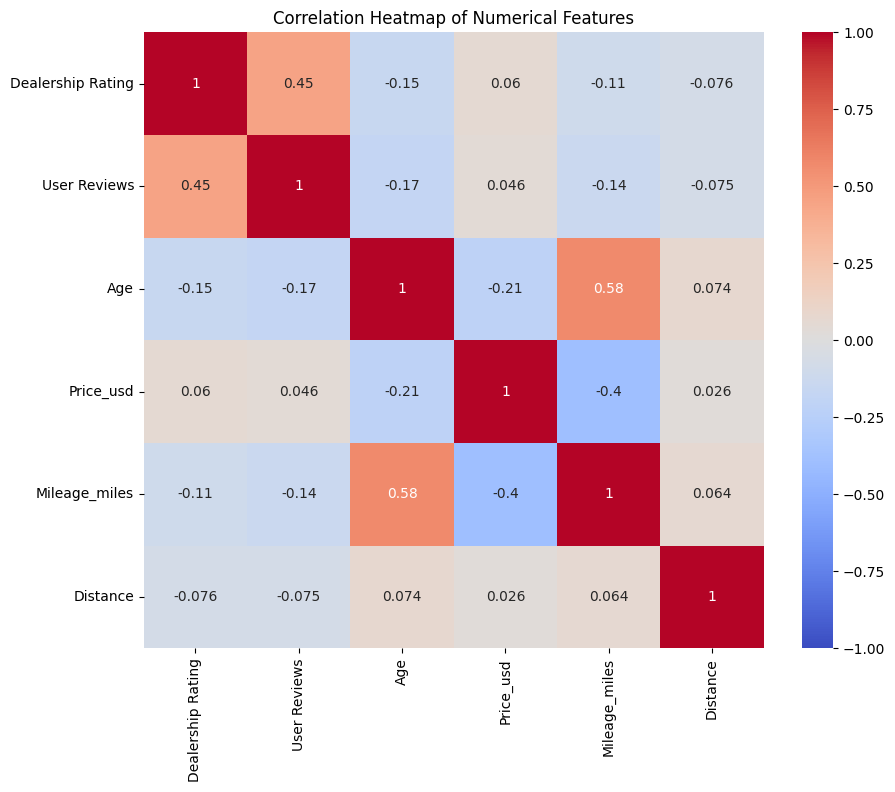

In [274]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns from the DataFrame
numerical_df = df_final.select_dtypes(include=['float64', 'int64'])

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


## Feature Engineering

In [275]:
# Checking for missing values
df_final.isnull().sum()

Dealer Name            2
Transmission Type      0
Drivetrain             0
Fuel Type              0
Dealership Rating    164
User Reviews         411
Year                   0
Make                   0
Model                  0
Age                    0
Price_usd            123
Mileage_miles          3
County               865
State                865
Distance             865
dtype: int64

In [276]:
# Impute missing numerical values with the mean
df_final['Dealership Rating'].fillna(df_final['Dealership Rating'].mean(), inplace=True)
df_final['User Reviews'].fillna(df_final['User Reviews'].mean(), inplace=True)
df_final['Price_usd'].fillna(df_final['Price_usd'].mean(), inplace=True)


In [277]:
# Checking for missing values
df_final.isnull().sum()

Dealer Name            2
Transmission Type      0
Drivetrain             0
Fuel Type              0
Dealership Rating      0
User Reviews           0
Year                   0
Make                   0
Model                  0
Age                    0
Price_usd              0
Mileage_miles          3
County               865
State                865
Distance             865
dtype: int64

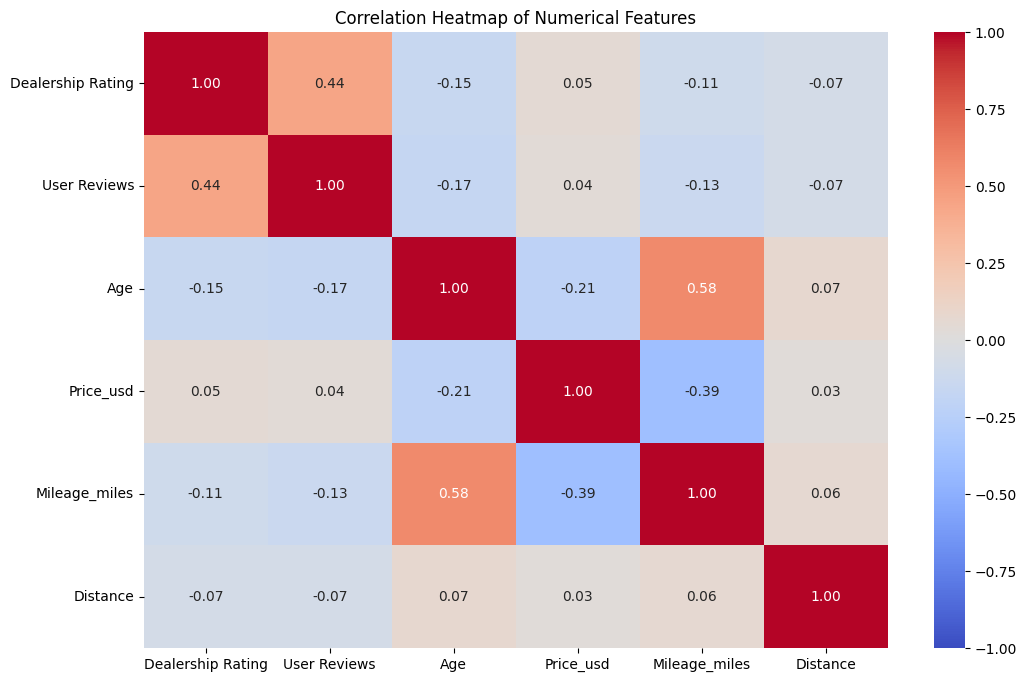

In [278]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting only numerical columns for correlation calculation
numerical_columns = df_final.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numerical_columns.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


Correlation of numerical features with 'Price_usd':
 Price_usd            1.000000
Dealership Rating    0.051230
User Reviews         0.038846
Distance             0.025385
Age                 -0.211503
Mileage_miles       -0.393986
Name: Price_usd, dtype: float64


/var/folders/gp/2k7ydjgd1pvdz7fcbjx5rvs00000gn/T/ipykernel_23007/2274064344.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




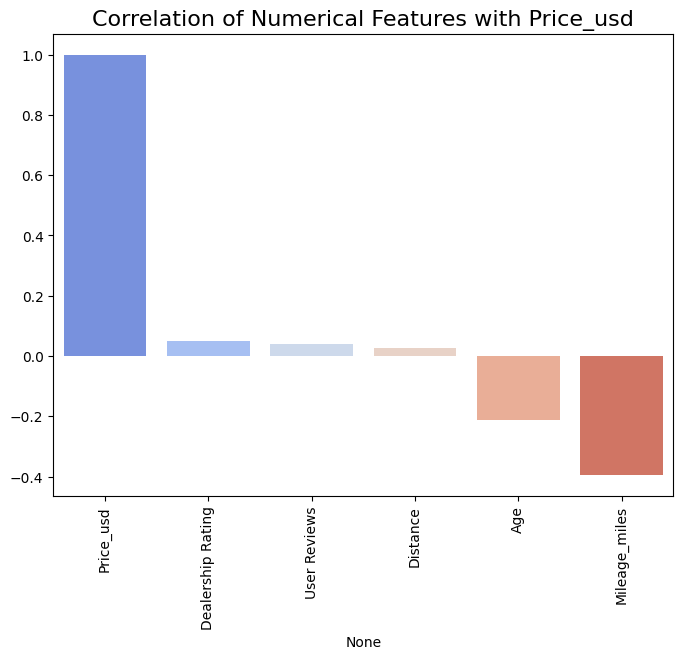

In [279]:
# Select numerical columns
numerical_columns = df_final.select_dtypes(include=['float64', 'int64'])

# Calculate correlation of all numerical features with 'Price_usd'
correlation_with_price = numerical_columns.corr()['Price_usd'].sort_values(ascending=False)

# Display the correlation with 'Price_usd'
print("Correlation of numerical features with 'Price_usd':\n", correlation_with_price)

# Plotting correlation with 'Price_usd'
plt.figure(figsize=(8, 6))
sns.barplot(x=correlation_with_price.index, y=correlation_with_price.values, palette='coolwarm')
plt.title('Correlation of Numerical Features with Price_usd', fontsize=16)
plt.xticks(rotation=90)
plt.show()


## Modeling

In [284]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np

# Impute missing numerical values with the median
num_imputer = SimpleImputer(strategy='median')
df_final[['Dealership Rating', 'User Reviews']] = num_imputer.fit_transform(df_final[['Dealership Rating', 'User Reviews']])
df_final['Mileage_miles'] = num_imputer.fit_transform(df_final[['Mileage_miles']])

# For Tree-based models: Label Encoding
label_cols = ['Transmission Type', 'Drivetrain', 'Fuel Type', 'Make', 'Model', 'County', 'State', 'Dealer Name']
df_tree = df_final.copy()  # Copy of the dataframe for tree-based models
label_encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df_tree[col] = le.fit_transform(df_tree[col])
    label_encoders[col] = le

X_tree = df_tree.drop(['Price_usd', 'Year', 'Distance'], axis=1)  # Dropping Year and Distance
y_tree = df_tree['Price_usd']

# Train-test split for tree-based models
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_tree, test_size=0.2, random_state=42)

# Define models for tree-based algorithms
models_tree_based = {
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}

# Train tree-based models (using Label Encoded dataset)
for name, model in models_tree_based.items():
    model.fit(X_train_tree, y_train_tree)
    y_pred = model.predict(X_test_tree)
    
    mse = mean_squared_error(y_test_tree, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_tree, y_pred)
    r2 = r2_score(y_test_tree, y_pred)
    explained_variance = explained_variance_score(y_test_tree, y_pred)
    
    print(f"{name} - Mean Squared Error: {mse:.4f}")
    print(f"{name} - Root Mean Squared Error: {rmse:.4f}")
    print(f"{name} - Mean Absolute Error: {mae:.4f}")
    print(f"{name} - R-squared: {r2:.4f}")
    print(f"{name} - Explained Variance: {explained_variance:.4f}")
    print("-" * 50)


# For Linear models: One-Hot Encoding
df_linear = pd.get_dummies(df_final, columns=label_cols, drop_first=True)
X_linear = df_linear.drop(['Price_usd', 'Year', 'Distance'], axis=1)  # Dropping Year and Distance
y_linear = df_linear['Price_usd']

# Train-test split for linear models
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X_linear, y_linear, test_size=0.2, random_state=42)

# Define models for linear algorithms
models_linear = {
    'Linear Regression': LinearRegression()
}

# Train linear models (using One-Hot Encoded dataset)
for name, model in models_linear.items():
    model.fit(X_train_linear, y_train_linear)
    y_pred = model.predict(X_test_linear)
    
    mse = mean_squared_error(y_test_linear, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_linear, y_pred)
    r2 = r2_score(y_test_linear, y_pred)
    explained_variance = explained_variance_score(y_test_linear, y_pred)
    
    print(f"{name} - Mean Squared Error: {mse:.4f}")
    print(f"{name} - Root Mean Squared Error: {rmse:.4f}")
    print(f"{name} - Mean Absolute Error: {mae:.4f}")
    print(f"{name} - R-squared: {r2:.4f}")
    print(f"{name} - Explained Variance: {explained_variance:.4f}")
    print("-" * 50)


Decision Tree - Mean Squared Error: 341441244.7590
Decision Tree - Root Mean Squared Error: 18478.1288
Decision Tree - Mean Absolute Error: 7819.6898
Decision Tree - R-squared: 0.5752
Decision Tree - Explained Variance: 0.5752
--------------------------------------------------
Random Forest - Mean Squared Error: 128745562.1218
Random Forest - Root Mean Squared Error: 11346.6102
Random Forest - Mean Absolute Error: 5725.2701
Random Forest - R-squared: 0.8398
Random Forest - Explained Variance: 0.8400
--------------------------------------------------
XGBoost - Mean Squared Error: 126251551.8148
XGBoost - Root Mean Squared Error: 11236.1716
XGBoost - Mean Absolute Error: 5065.6793
XGBoost - R-squared: 0.8429
XGBoost - Explained Variance: 0.8429
--------------------------------------------------
Linear Regression - Mean Squared Error: 41245000214348234752.0000
Linear Regression - Root Mean Squared Error: 6422227044.7523
Linear Regression - Mean Absolute Error: 1109141207.6643
Linear Regre